## HOG + SVM Player detector
**This notebook aims to create a model to detect players**

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import os
from glob import glob
import scipy.io
import pandas as pd
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

**1. Get the dataset**

In [2]:
#FIXME : Put it in a util.py file
def get_image_paths(data_path, fmt='jpg'):
    """
    This function returns lists containing the file path for each train 
    image, as well as lists with the label of each train image.
    :param data_path: path to the 'train' directories
    :param fmt: file extension of the images
    :return: lists: train_image_paths, train_labels
    """
    train_image_paths = []
    train_labels = []

    # train
    pth = os.path.join(data_path, '*.{:s}'.format(fmt))
    pth = glob(pth)
    train_image_paths.extend(pth)

    return train_image_paths

train_image_paths = get_image_paths("./dataset/DataSet_001")

In [3]:
#Now we get the labels 
mat_1 = scipy.io.loadmat('./dataset/annotation_1.mat')['annot'].flatten()

In [4]:
df_ground_truth = pd.DataFrame(mat_1)

In [5]:
#FIXME : Put it in a util.py file
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from skimage.io import imread
from skimage.transform import resize

H, W = 720, 1280
N = len(df_ground_truth)

def read_frame(train_image_paths, frame):
    file_path = train_image_paths[frame]
    img = cv2.imread(f"./dataset/DataSet_001/{file_path[0]}",cv2.IMREAD_GRAYSCALE)
    img = resize(img, output_shape=(H,W))
    return img

def annotations_for_frame(df_annotation, frame):
    assert frame in df_annotation.index
    bbs = df_annotation[df_annotation.index == frame].values[0]
    return bbs

def show_annotation(df_annotation, frame):
    img = read_frame(df_annotation['ImgName'], frame)
    bbs = annotations_for_frame(df_annotation['BBox'], frame)
    fig, ax = plt.subplots(figsize=(20, 12))
    print(type(ax))
    for x1, y1, x2, y2 in bbs:
        dx = x2 - x1
        dy = y2 - y1
        rect = patches.Rectangle((x1, y1), dx, dy, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    ax.imshow(img)
    ax.set_title('Annotations for frame {}.'.format(frame))

def bounding_boxes_to_mask(bounding_boxes, H, W):
    
    """
    Converts set of bounding boxes to a binary mask
    """
    mask = np.zeros((H, W))
    for x1, y1, x2, y2 in bounding_boxes:
        dx = x2 - x1
        dy = y2 - y1
        mask[y1:y2,x1:x2] = 1
    return mask

def run_length_encoding(mask):

    """
    Produces run length encoding for a given binary mask
    """
    
    # find mask non-zeros in flattened representation
    non_zeros = np.nonzero(mask.flatten())[0]
    padded = np.pad(non_zeros, pad_width=1, mode='edge')
    
    # find start and end points of non-zeros runs
    limits = (padded[1:] - padded[:-1]) != 1
    starts = non_zeros[limits[:-1]]
    ends = non_zeros[limits[1:]]
    lengths = ends - starts + 1
    
    return ' '.join(['%d %d' % (s, l) for s, l in zip(starts, lengths)])

**2. Show the dataset**

In [6]:
from ipywidgets import interact, widgets
from IPython.display import display

def f_display_frame(frame_id):
    show_annotation(df_ground_truth,frame_id)

interact(f_display_frame, frame_id=widgets.IntSlider(min=1, max=1493, step=1, value=1))

interactive(children=(IntSlider(value=1, description='frame_id', max=1493, min=1), Output()), _dom_classes=('w…

<function __main__.f_display_frame(frame_id)>

**3. Create the HOG descriptor (preprocess)**

In [57]:
from IPython.display import clear_output

**3.1 Get the positive samples**

In [78]:
#Code to save the cropped img in the directory
from IPython.display import clear_output
'''def getpos_sample(df_labels):
    pos_samples = []
    for i in range(0,1492):
        all_pos = df_labels[df_labels.index == i].values[0]
        path = df_labels[df_labels.index == i]["ImgName"].values[0]
        
        img = cv2.imread(f"./dataset/DataSet_001/{path[0]}")
        img = resize(img, output_shape=(H,W,3))
        
        for pos in all_pos[0]:
            cropped_img = np.array(img[int(pos[1]):int(pos[3]),int(pos[0]):int(pos[2])])
            cropped_img = resize(cropped_img, output_shape=(128,64,3))
            pos_samples.append(cropped_img) 
        clear_output(wait=True)
        print(f"{i+1}/{1492}")
        
    return pos_samples
pos_samples = getpos_sample(df_ground_truth)
for i in range(1000):
    cv2.imwrite(f'./dataset/pos_player/img_{i}.png',np.array(pos_samples[i])*255)'''

1492/1492


In [112]:
def list_samples(directory):
    my_list = []
    for i in range(1000):
        img = cv2.imread(f"{directory}/img_{i}.png")
        my_list.append(img)
    return my_list

In [81]:
pos_samples = list_samples('./dataset/pos_player')

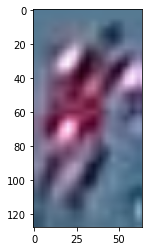

In [82]:
plt.imshow(pos_samples[820])

**3.2 Get the negative samples**
To get the negative samples we take random crops of the dataset without players (from img nb 81 for exemple)

In [83]:
import random
'''def getneg_sample(df_labels):
    neg_sample = []
    random.seed(1)
    for i in range(0,1492):
        path = df_labels[df_labels.index == i]["ImgName"].values[0]
        
        img = cv2.imread(f"./dataset/DataSet_001/{path[0]}")
        #img = resize(img, output_shape=(H,W,3))
        
        y = int(random.random() * (H - 128))
        x = int(random.random() * (W - 64))
        
        cropped_img = np.array(img[y:y + 128, x:x + 64])
        neg_sample.append(cropped_img) 
        
        clear_output(wait=True)
        print(f"{i+1}/{1492}")
    return np.array(neg_sample)
neg_samples = getneg_sample(df_ground_truth) 
    
for i in range(1000):
    cv2.imwrite(f'./dataset/neg_player/img_{i}.png',np.array(neg_samples[i])*255)'''
#Hoping random didn't select a player 

1492/1492


In [110]:
neg_samples = list_samples('./dataset/neg_player')

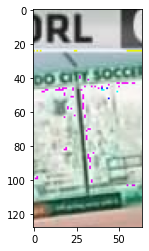

In [111]:
plt.imshow(neg_samples[578]) 

**3.3 Now the HOG**

In [113]:
#Calculate HOG features
def getHOGList(imageList):
    HOGList = []
    hog = cv2.HOGDescriptor()
    for i in range(len(imageList)):
        gray = cv2.cvtColor(imageList[i], cv2.COLOR_BGR2GRAY)
        HOGList.append(hog.compute(gray))
    return HOGList
HOG_list = getHOGList(pos_samples)
HOG_list.extend(getHOGList(neg_samples))

In [114]:
np.array(HOG_list).shape

(1600, 3780, 1)

In [115]:
#Add the label corresponding to all positive samples
labels = []
for _ in range(1000):
    labels.append(+1)

In [116]:
for _ in range(600):
    labels.append(-1)

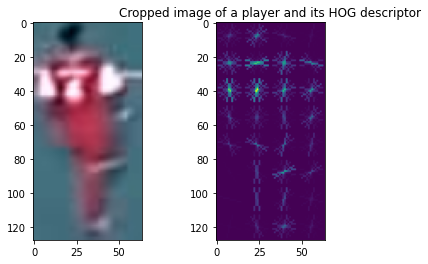

In [141]:
from skimage.feature import hog
index = 0
plt.subplot(1,2,1)
plt.imshow(pos_samples[index])
plt.subplot(1,2,2)
fd,hog_image = hog(pos_samples[index], orientations=8, pixels_per_cell=(16,16),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
plt.imshow(hog_image)
plt.title('Cropped image of a player and its HOG descriptor')
plt.show()

**4. Let's create the SVM classifier**

In [118]:
#Get detector
def getHOGDetector(svm):
    sv = svm.getSupportVectors()
    rho, _, _ = svm.getDecisionFunction(0)
    sv = np.transpose(sv)
    return np.append(sv, [[-rho]], 0)

In [119]:
#FIXME : maybe try the svm from sklearn ..
#We create a first classifier
svm = cv2.ml.SVM_create()

svm.setCoef0(0.0)
svm.setDegree(3)
criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 1000, 1e-3)#Termination condition
svm.setTermCriteria(criteria)
svm.setGamma(0)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setNu(0.5)
svm.setP(0.1)  # for EPSILON_SVR, epsilon in loss function?
svm.setC(0.01)  # From paper, soft classifier 
svm.setType(cv2.ml.SVM_EPS_SVR)  # C_SVC # EPSILON_SVR # may be also NU_SVR # do regression task
print(type(cv2.ml.ROW_SAMPLE))
svm.train(np.array(HOG_list), cv2.ml.ROW_SAMPLE, np.array(labels))

<class 'int'>


True

In [120]:
#Get Hard example
def getHardExamples(negImageList, svm):
    hardNegList = []
    hog = cv2.HOGDescriptor()
    hog.setSVMDetector(getHOGDetector(svm))
    for i in range(len(negImageList)):
        rects, wei = hog.detectMultiScale(negImageList[i], winStride=(4, 4),padding=(8, 8), scale=1.05)
        for (x,y,w,h) in rects:
            hardExample = negImageList[i][y:y+h, x:x+w]
            hardNegList.append(cv2.resize(hardExample,(64,128)))
    return hardNegList

In [121]:
#Acquire hard example based on initial training results
hardNegList = getHardExamples(neg_samples, svm)
HOG_list.extend(getHOGList(hardNegList))
print ("hosList=====", len(HOG_list))
[labels.append(-1) for _ in range(len(hardNegList))]

hosList===== 1612


[None, None, None, None, None, None, None, None, None, None, None, None]

**5. We save the model**

In [122]:
#retrain with the hard exemple
svm.train(np.array(HOG_list), cv2.ml.ROW_SAMPLE, np.array(labels))

#Save model
hog = cv2.HOGDescriptor()
hog.setSVMDetector(getHOGDetector(svm))
hog.save('myHogPlayerDector.bin')

**6. Let's test our model**

**6.1. We predict the bounding boxes**

In [123]:
#Player detection
hog = cv2.HOGDescriptor()
hog.load('myHogPlayerDector.bin')
image = cv2.imread("input_img1.png")
#image = cv2.imread("./dataset/DataSet_002/0237.jpg")
rects, scores = hog.detectMultiScale(image, winStride=(4, 4),padding=(8, 8), scale=1.05)

**6.2. We apply the fast Non Max Suppression**

In [124]:
#FIXME : Put it in the utils.py 
#Non-maximum suppression
def fastNonMaxSuppression(boxes, sc, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    scores = sc
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the score of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last],
                                               np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick]

In [125]:
#fastNonMaxSuppression-The first parameter
for i in range(len(rects)):
    r = rects[i]
    rects[i][2] = r[0] + r[2]
    rects[i][3] = r[1] + r[3]

#fastNonMaxSuppression-Second parameter
sc = [score[0] for score in scores]
sc = np.array(sc)

pick = []
print('rects_len',len(rects))
pick = fastNonMaxSuppression(rects, sc, overlapThresh = 0.3)
print('pick_len = ',len(pick))

rects_len 51
pick_len =  42


In [126]:
bbox = []
for i in range(len(scores)):
    if (scores[i] > 0.3):
        bbox.append(rects[i])
bbox = np.array(bbox)

Text(0.5, 1.0, 'Prediction for frame {}')

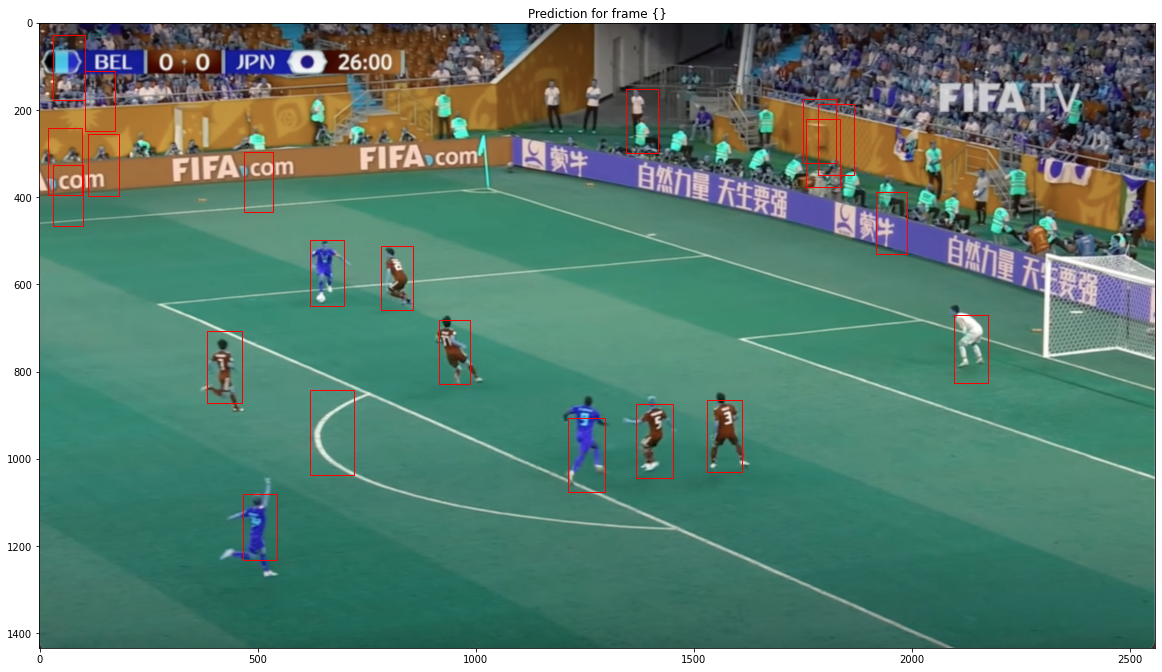

In [127]:
fig, ax = plt.subplots(figsize=(20, 12))
img = image
for x1, y1, x2, y2 in bbox:
    dx = x2 - x1
    dy = y2 - y1
    rect = patches.Rectangle((x1, y1), dx, dy, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.imshow(img)
ax.set_title('Prediction for frame {}')